In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from sqlalchemy import create_engine

In [3]:
# connect to mongo db
client = MongoClient('mongodb://localhost:27017/')
db = client.pokemon_db

In [4]:
# get pokemon encount collection 
col_encount = db['pokemon_encount']
pokemon_encount = pd.DataFrame(list(col_encount.find()))

In [5]:
# get area encount collection
col_area = db['area_encount']
area_encount = pd.DataFrame(list(col_area.find()))

In [6]:
# get pokemon catch rate data collection
col_catch_pokemon = db['pokemon_catch']
pokemon_catch = pd.DataFrame(list(col_catch_pokemon.find()))

In [44]:
sns.set(color_codes=True)

# area encount pokemon & catch rate

In [10]:
area_encount_df = area_encount[['avg_catch_one_pokemon', 'name', 'num_method_to_catch', 'num_pokemon_encounter']]

#pokemon encounter number by area

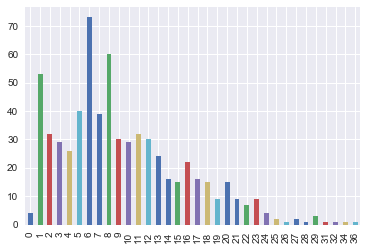

In [45]:
area_encount_df.num_pokemon_encounter.value_counts().sort_index().plot.bar()

In [22]:
# avg possible number of encounter pokemon by location area
np.mean(area_encount_df.num_pokemon_encounter)

9.402457757296467

In [23]:
np.median(area_encount_df.num_pokemon_encounter)

8.0

#methods trigger pokemon by area

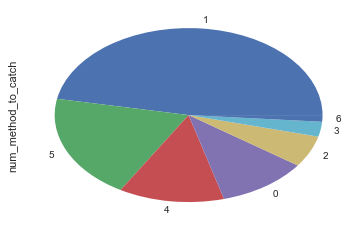

In [46]:
area_encount_df.num_method_to_catch.value_counts().plot.pie()

#common metheds are not available to trigger out pokemon in 71 areas 

In [28]:
area_encount_df.loc[area_encount_df.num_method_to_catch == 0].count()

avg_catch_one_pokemon    67
name                     71
num_method_to_catch      71
num_pokemon_encounter    71
dtype: int64

In [24]:
np.count_nonzero(area_encount_df.num_method_to_catch)

580

In [34]:
# catch rate with availbal methods
area_methods_ok = area_encount_df.loc[area_encount_df.num_method_to_catch != 0]
area_methods_ok.head()

,avg_catch_one_pokemon,name,num_method_to_catch,num_pokemon_encounter
0,10.16,canalave-city-area,4,11
1,15.17,eterna-city-area,4,6
2,10.05,pastoria-city-area,4,10
3,11.72,sunyshore-city-area,4,10
4,14.22,sinnoh-pokemon-league-area,4,8


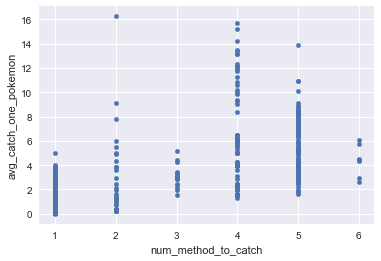

In [47]:
# number of methods VS avg rate of catch one pokemon
area_methods_ok.plot.scatter(x='num_method_to_catch', y='avg_catch_one_pokemon')

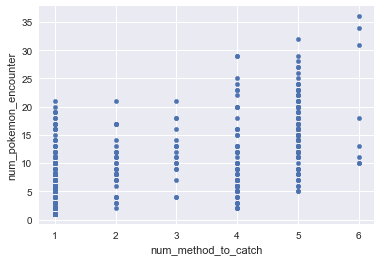

In [49]:
# number of methods VS number of possible encount pokemon
area_methods_ok.plot.scatter(x='num_method_to_catch', y='num_pokemon_encounter')

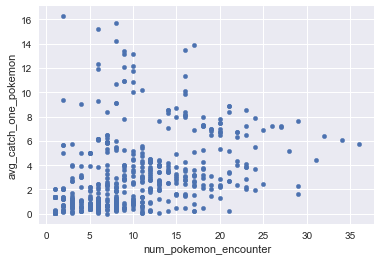

In [48]:
# number of methods VS avg rate of catch one pokemon
area_methods_ok.plot.scatter(x='num_pokemon_encounter', y='avg_catch_one_pokemon')

In [39]:
area_methods_ok.describe()

,avg_catch_one_pokemon,num_method_to_catch,num_pokemon_encounter
count,580.000000,580.000000,580.000000
mean,2.887397,2.501724,9.501724
std,2.991982,1.753850,6.545048
min,0.000000,1.000000,1.000000
25%,0.685000,1.000000,5.000000
50%,1.990000,1.000000,8.000000
75%,4.002500,4.000000,13.000000
max,16.250000,6.000000,36.000000


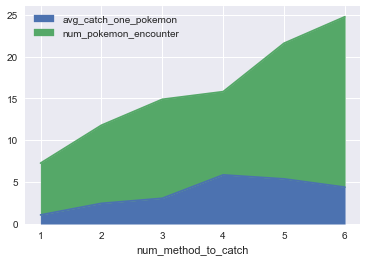

In [50]:
area_methods_ok.groupby('num_method_to_catch').mean().plot.area()

In [63]:
area_encount_df.sort_values(by='avg_catch_one_pokemon', ascending=False)[:10]

,avg_catch_one_pokemon,name,num_method_to_catch,num_pokemon_encounter
419,16.25,mt-ember-b3f,2,2
236,15.74,viridian-city-area,4,8
1,15.17,eterna-city-area,4,6
4,14.22,sinnoh-pokemon-league-area,4,8
238,13.91,vermilion-city-area,5,17
241,13.50,pallet-town-area,4,16
141,13.42,sinnoh-sea-route-223-area,4,9
237,13.18,cerulean-city-area,4,10
129,13.17,sinnoh-route-219-area,4,9
139,12.35,resort-area-area,4,6


#method efficient

In [111]:
method_efficient = pd.DataFrame(
    data = {
        'name': area_encount_df.name,
        'method_rate': np.round(area_encount_df.avg_catch_one_pokemon / area_encount_df.num_method_to_catch, decimals=2),
        'method_per_pokemon': np.round(area_encount_df.num_pokemon_encounter / area_encount_df.num_method_to_catch, decimals=2)
    }
)

In [116]:
area_efficient = area_encount_df.merge(method_efficient, on='name')

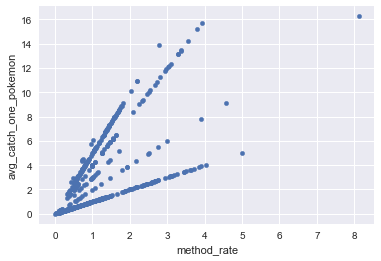

In [118]:
area_efficient.plot.scatter(x='method_rate', y='avg_catch_one_pokemon')

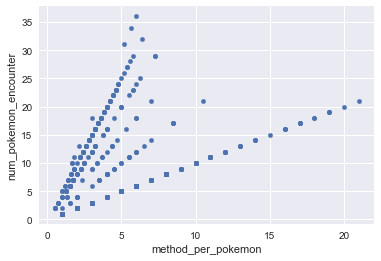

In [123]:
area_efficient.plot.scatter(x='method_per_pokemon', y='num_pokemon_encounter')

In [161]:
relation_df = pd.DataFrame(
    data ={
        'pokemon_relation': np.round(area_efficient.num_pokemon_encounter / area_efficient.method_per_pokemon, decimals=0),
        'name': area_efficient.name,
        'rate_relation': np.round(area_efficient.avg_catch_one_pokemon / area_efficient.method_rate, decimals=0)
    }
)

In [162]:
relation_df = relation_df.merge(area_efficient, on='name')
relation_df = relation_df.loc[relation_df.num_method_to_catch != 0]

In [166]:
relation_final = relation_df.loc[relation_df.pokemon_relation == relation_df.rate_relation].drop(columns=['pokemon_relation'])

In [170]:
relation_final.rate_relation.value_counts()

1.0    305
5.0    127
4.0     83
2.0     38
3.0     18
6.0      8
Name: rate_relation, dtype: int64

In [191]:
relation_final.head()

,name,rate_relation,avg_catch_one_pokemon,num_method_to_catch,num_pokemon_encounter,method_per_pokemon,method_rate
0,canalave-city-area,4.0,10.16,4,11,2.75,2.54
1,eterna-city-area,4.0,15.17,4,6,1.50,3.79
2,pastoria-city-area,4.0,10.05,4,10,2.50,2.51
3,sunyshore-city-area,4.0,11.72,4,10,2.50,2.93
4,sinnoh-pokemon-league-area,4.0,14.22,4,8,2.00,3.56


# Pokemon Catch Rate

In [88]:
pokemon_catch_df = pokemon_catch[['catch_rate_avg', 'name']].groupby('name').mean().reset_index()

In [90]:
pokemon_catch_df.sort_values(by='catch_rate_avg', ascending=False)[:10]

,name,catch_rate_avg
128,finneon,21.600000
468,whiscash,18.475000
49,carvanha,18.200000
227,lumineon,16.750000
166,gyarados,16.650943
285,octillery,15.053125
151,goldeen,14.881443
17,barboach,12.969697
19,basculin-red-striped,12.641304
335,remoraid,12.413462


# pokemon_encount 

In [79]:
pokemon_encount_df = pokemon_encount[['area', 'catch_rate_avg', 'chance_avg', 'chance_dif_avg', 'max_chance_avg', 'name']]

In [80]:
pokemon_encount_df = pokemon_encount_df.rename(columns={'catch_rate_avg': 'encount_rate_avg'})

In [91]:
pokemon_encount_merge = pokemon_encount_df.merge(pokemon_catch_df, left_on='name', right_on='name', how='outer')

In [106]:
pokemon_catch_filtered = pokemon_encount_merge.loc[pokemon_encount_merge.catch_rate_avg != 0]

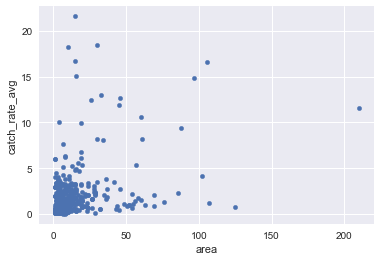

In [107]:
pokemon_catch_filtered.plot.scatter(x='area', y='catch_rate_avg')

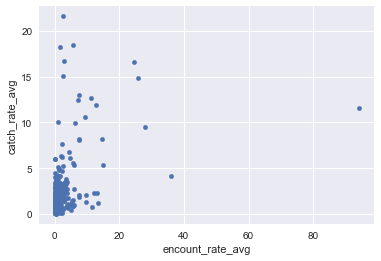

In [109]:
pokemon_catch_filtered.plot.scatter(x='encount_rate_avg', y='catch_rate_avg')

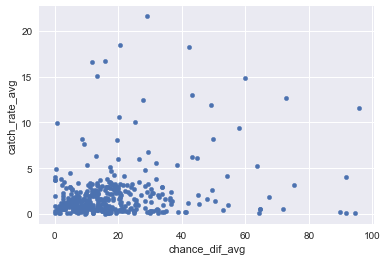

In [108]:
pokemon_catch_filtered.plot.scatter(x='chance_dif_avg', y='catch_rate_avg')